In [10]:
import re
import os
import sys
sys.path.insert(0, '../src/')

import numpy as np
rng = np.random.RandomState(0)

import matplotlib.pyplot as plt
import scipy.stats as stats
import astropy.units as u
import pandas as pd

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

nlive_init=100
nlive_batch=25
maxbatch=2
pfrac=0.8

dlogz = 1e-3 * (nlive_init - 1) + 0.01

def get_params_fit(results, return_sample=False):
    samples = results.samples                                 # samples
    weights = np.exp(results.logwt - results.logz[-1])        # normalized weights 
    pmean, pcov = dyfunc.mean_and_cov(samples, weights)       # weighted mean and covariance
    samples_eq = dyfunc.resample_equal(samples, weights)      # resample weighted samples
    pmed = np.median(samples_eq,axis=0)
    
    if return_sample:
        return pmed, pmean, pcov, samples_eq
    else:
        return pmed, pmean, pcov
    
%load_ext autoreload
%autoreload 2

### Toy Model 1

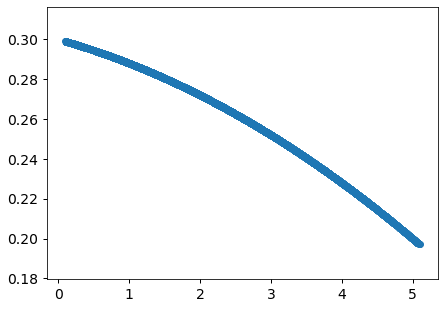

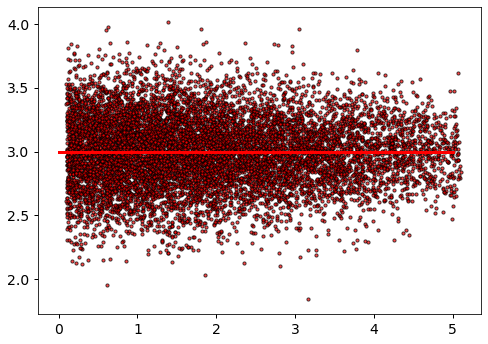

In [39]:
k1 = -0.002
k2 = -0.01
b = 0.3

x = stats.truncnorm(loc=0.1, scale=2.5, a=0, b=2).rvs(10000)
X = x[:, np.newaxis]
y = 3 + rng.normal(0, k1*x**2 + k2*x + b, X.shape[0])

plt.scatter(x, k1*x**2 + k2*x + b)

plt.figure(figsize=(7,5))
X_ = np.linspace(0, 5, 100)
plt.scatter(X[:, 0], y, c='r', s=10, edgecolors=(0, 0, 0), alpha=0.7)
plt.plot(X_, 3*np.ones_like(X_), 'r', lw=3)
plt.tight_layout()

In [47]:
def prior(u):
    v = u.copy()
    v[0] = u[0] * 2 + 2
    v[1] = u[1] * 0.02 - 0.01
    v[2] = u[2] * 0.2 -0.1
    v[3] = u[3] * 0.5
    return v

def loglike(v):
    mu, k1, k2, b = v

    ypred = mu
    sigma = (k1 * x**2 + k2 * x + b)
    if min(sigma)<=0:
        loglike = -1e100
    
    residsq = (ypred - y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))

    if not np.isfinite(loglike):
        loglike = -1e100

    return loglike

In [48]:
pdsampler = dynesty.DynamicNestedSampler(loglike, prior, 4)
pdsampler.run_nested(nlive_init=nlive_init, 
                     nlive_batch=nlive_batch, 
                     maxbatch=maxbatch, 
                     dlogz_init=dlogz, 
                     wt_kwargs={'pfrac': pfrac})

2069it [00:22, 90.52it/s, batch: 2 | bound: 34 | nc: 4 | ncall: 7485 | eff(%): 27.642 | loglstar: -1127.068 < -1123.646 < -1124.554 | logz: -1139.326 +/-  0.530 | stop:  4.855]       


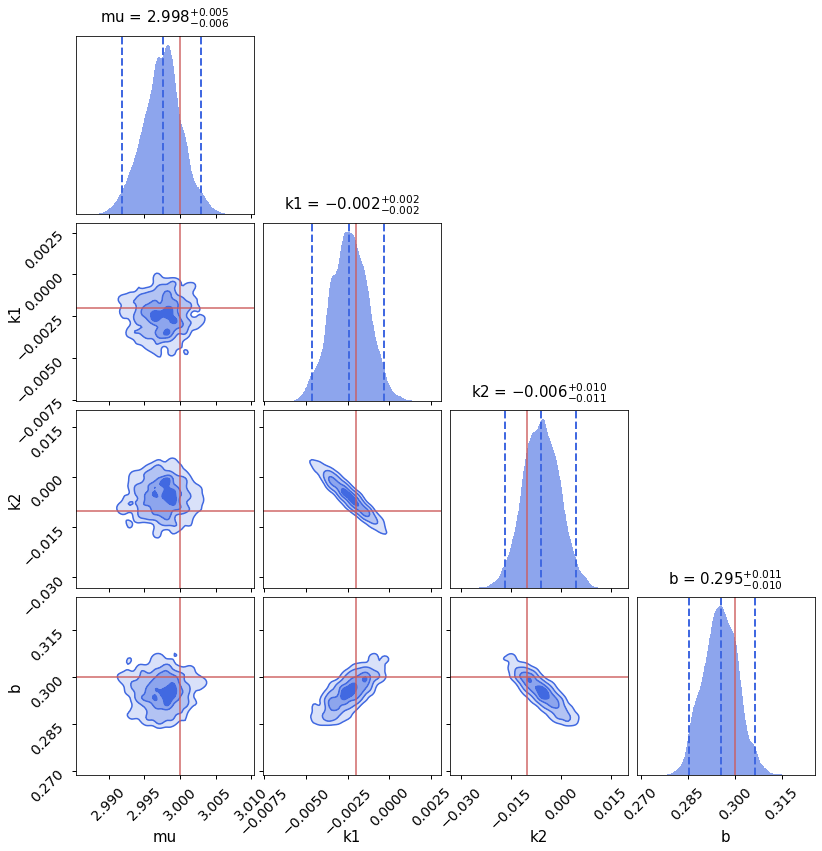

In [49]:
fig, ax = plt.subplots(4,4,figsize=(12,12))
dyplot.cornerplot(pdsampler.results, truths=[3, k1, k2, b], labels=["mu", "k1", "k2", "b"], 
                  color="royalblue", truth_color="indianred",
                  title_kwargs={'fontsize':15, 'y': 1.04}, title_fmt='.3f',
                  label_kwargs={'fontsize':15}, show_titles=True, fig=(fig,ax))
plt.show()

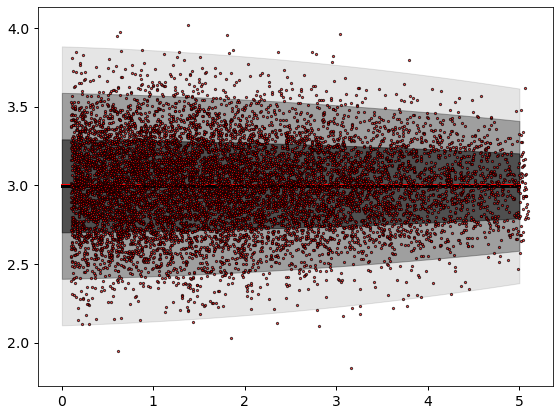

In [52]:
pmed, pmean, pcov = get_params_fit(pdsampler.results) 

plt.figure(figsize=(8,6))
Xp = np.linspace(0, 5, 100)
yp_mean, yp_std = pmed[0], pmed[1] * Xp**2 + pmed[2] * Xp + pmed[3]
plt.plot(Xp, yp_mean*np.ones_like(Xp), 'k', lw=3, zorder=9)
plt.fill_between(Xp, yp_mean - yp_std, yp_mean + yp_std, alpha=0.5, color='k')
plt.fill_between(Xp, yp_mean - 2*yp_std, yp_mean + 2*yp_std, alpha=0.3, color='k')
plt.fill_between(Xp, yp_mean - 3*yp_std, yp_mean + 3*yp_std, alpha=0.1, color='k')
plt.scatter(X[:, 0], y, c='r', s=5, zorder=10, edgecolors=(0, 0, 0), alpha=0.7)
plt.plot(Xp, 3*np.ones_like(Xp), 'r', lw=3)
plt.tight_layout()

### Toy Model 2

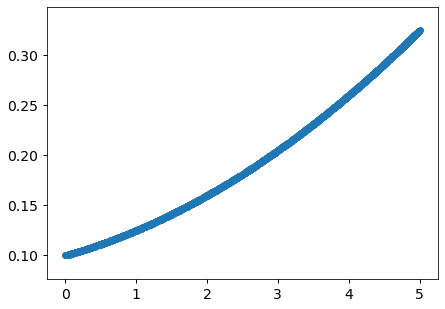

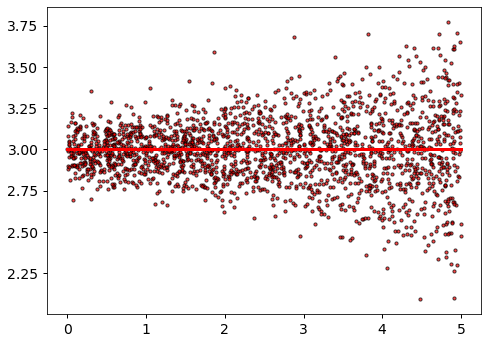

In [61]:
k1 = 0.005
k2 = 0.02
b = 0.1

x = rng.uniform(0, 5, 2000)
X = x[:, np.newaxis]
y = 3 + rng.normal(0, k1*x**2 + k2*x + b, X.shape[0])

plt.scatter(x, k1*x**2 + k2*x + b)

plt.figure(figsize=(7,5))
X_ = np.linspace(0, 5, 100)
plt.scatter(X[:, 0], y, c='r', s=10, edgecolors=(0, 0, 0), alpha=0.7)
plt.plot(X_, 3*np.ones_like(X_), 'r', lw=3)
plt.tight_layout()

In [57]:
pdsampler = dynesty.DynamicNestedSampler(loglike, prior, 4)
pdsampler.run_nested(nlive_init=nlive_init, 
                     nlive_batch=nlive_batch, 
                     maxbatch=maxbatch, 
                     dlogz_init=dlogz, 
                     wt_kwargs={'pfrac': pfrac})

2009it [00:12, 157.41it/s, batch: 2 | bound: 31 | nc: 1 | ncall: 7801 | eff(%): 25.753 | loglstar: 620.035 < 623.526 < 622.343 | logz: 608.291 +/-  0.521 | stop:  4.884]            


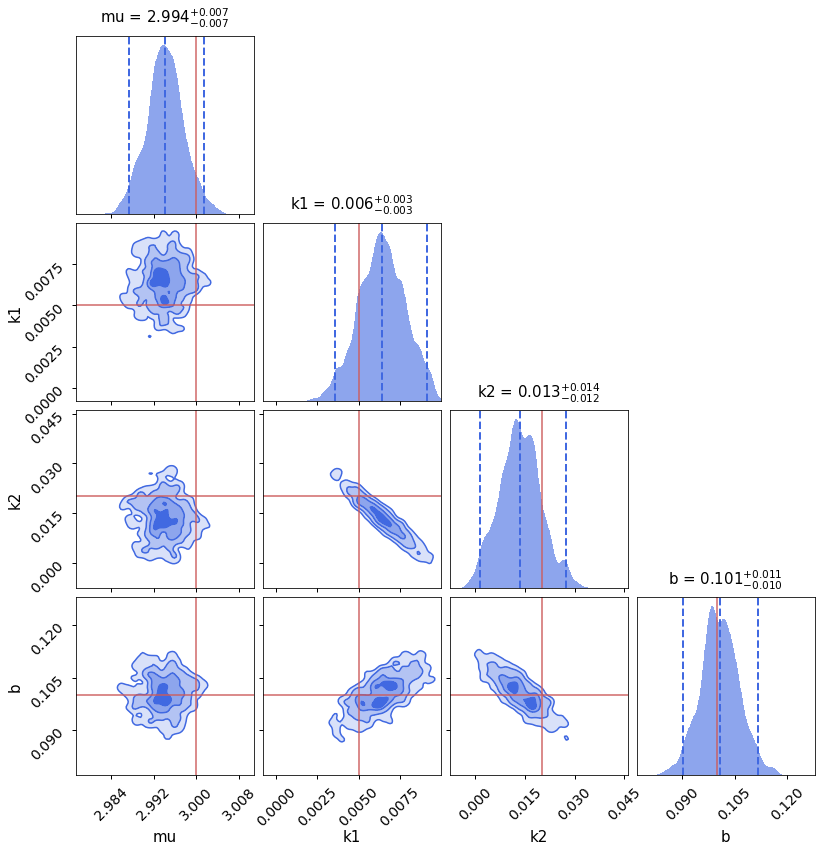

In [58]:
fig, ax = plt.subplots(4,4,figsize=(12,12))
dyplot.cornerplot(pdsampler.results, truths=[3, k1, k2, b], labels=["mu", "k1", "k2", "b"], 
                  color="royalblue", truth_color="indianred",
                  title_kwargs={'fontsize':15, 'y': 1.04}, title_fmt='.3f',
                  label_kwargs={'fontsize':15}, show_titles=True, fig=(fig,ax))
plt.show()

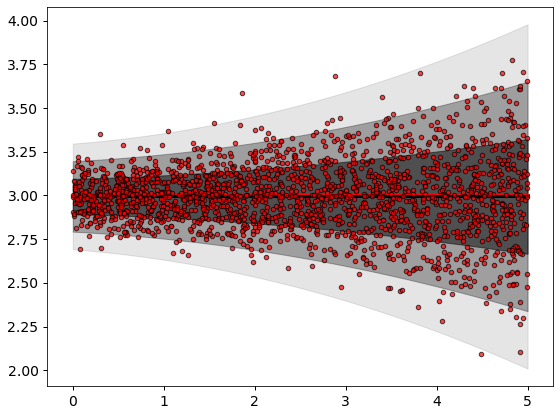

In [59]:
pmed, pmean, pcov = get_params_fit(pdsampler.results) 

plt.figure(figsize=(8,6))
Xp = np.linspace(0, 5, 100)
yp_mean, yp_std = pmed[0], pmed[1] * Xp**2 + pmed[2] * Xp + pmed[3]
plt.plot(Xp, yp_mean*np.ones_like(Xp), 'k', lw=3, zorder=9)
plt.fill_between(Xp, yp_mean - yp_std, yp_mean + yp_std, alpha=0.5, color='k')
plt.fill_between(Xp, yp_mean - 2*yp_std, yp_mean + 2*yp_std, alpha=0.3, color='k')
plt.fill_between(Xp, yp_mean - 3*yp_std, yp_mean + 3*yp_std, alpha=0.1, color='k')
plt.scatter(X[:, 0], y, c='r', s=20, zorder=10, edgecolors=(0, 0, 0), alpha=0.7)
plt.plot(Xp, 3*np.ones_like(Xp), 'r', lw=3)
plt.tight_layout()